In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import random
import pandas as pd
np.random.seed(1234)

In [9]:
from utils import ThousandLandmarksDataset
from torch.utils.data import DataLoader
from utils import ScaleMinSideToSize, CropCenter, CROP_SIZE, TransformByKeys
from torchvision.transforms import transforms
import torch
from train import init_model
import tqdm
from torch.nn import functional as fnn
import itertools
from utils import restore_landmarks

In [4]:
train_path = './data/train/images/'
test_path = './data/test/images/'
train_img_names = [os.path.join(train_path, name) for name in os.listdir(train_path)]
test_img_names = [os.path.join(test_path, name) for name in os.listdir(test_path)]

In [8]:
from torchvision.transforms import transforms

In [5]:
def read_img(img_name):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [8]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),
])

## filter data

In [14]:
model = init_model()
with open(os.path.join("runs", "resnet-layer4_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

Creating model...


In [15]:
train_dataset = ThousandLandmarksDataset("./data/train", train_transforms, split="train")
train_dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4, pin_memory=True,
                              shuffle=True, drop_last=False)
val_dataset = ThousandLandmarksDataset("./data/train", train_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True,
                            shuffle=False, drop_last=False)

 80%|███████▉  | 51200/64001 [00:15<00:03, 3267.59it/s]


In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
loss_fn = fnn.mse_loss
model.eval()
model.requires_grad_(False)
model.to(device)
loss_list = []
batch_size = 64

In [19]:
for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc="validation..."):
    images = batch["image"].to(device)
    landmarks = batch["landmarks"].to(device)
    fs = batch["scale_coef"].numpy()  # B
    margins_x = batch["crop_margin_x"].numpy()  # B
    margins_y = batch["crop_margin_y"].numpy()  # B
#     prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)

    with torch.no_grad():
        pred_landmarks = model(images)
    loss = loss_fn(pred_landmarks, landmarks, reduction='none').to('cpu')
    loss_list.append(
        (
            batch['image_name'], 
            loss.numpy(),
            {
                'landmarks': landmarks.to('cpu').numpy(),
                'predictions': pred_landmarks.to('cpu').numpy(),
                'scale_coef': fs,
                "crop_margin_x": margins_x,
                "crop_margin_y": margins_y
            }
        )
    )

validation...: 100%|██████████| 800/800 [00:23<00:00, 34.71it/s]


In [20]:
loss_np = np.concatenate([np.mean(l, axis=-1) for _, l, _ in loss_list])
img_names = list(itertools.chain(*[n for n, _, _ in loss_list]))

landmarks = np.array(list(itertools.chain(*[b['landmarks'].reshape(-1, 971, 2) for _, _, b in loss_list])))
pred_landmarks = np.array(list(itertools.chain(*[b['predictions'].reshape(-1, 971, 2) for _, _, b in loss_list])))

In [22]:
scale_coef = np.array(list(itertools.chain(*[b['scale_coef'] for _, _, b in loss_list])))
margins_x = np.array(list(itertools.chain(*[b['crop_margin_x'] for _, _, b in loss_list])))
margins_y = np.array(list(itertools.chain(*[b['crop_margin_y'] for _, _, b in loss_list])))

In [27]:
img_loss = list(zip(
    img_names,
    loss_np,
    landmarks,
    pred_landmarks,
    scale_coef,
    margins_x,
    margins_y
))
img_loss = sorted(img_loss, key=lambda x: x[1])

In [29]:
def draw_landmarks(image, landmarks, color=(128, 0, 128)):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, color, 1, -1)
    return image

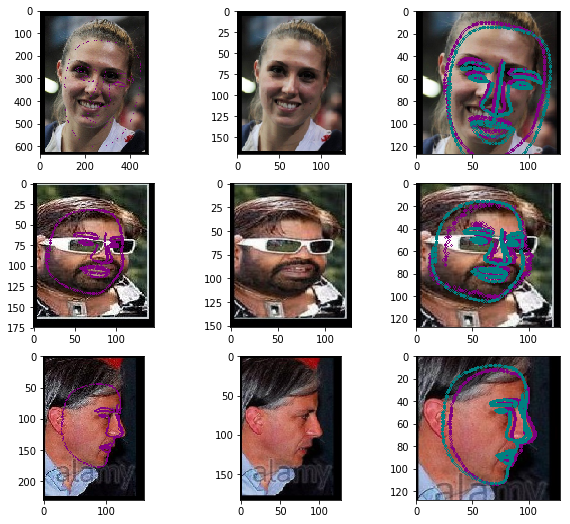

In [59]:
bad_img = img_loss[-500:]
IMG_N = 3
plt_img_names = random.sample(bad_img, IMG_N)
plt_img = [(read_img(smth[0]), *smth[1:]) for smth in plt_img_names]

plt.figure(figsize=(10, IMG_N * 3))
for i, smth in enumerate(plt_img):
    img, _, lm, pm, sc, m_x, m_y = smth
    
    scale_img = scalemin({'image': img})['image']
    plt.subplot(3, IMG_N, i * 3 + 2)
    plt.imshow(scale_img)
    
    crop_img = crop_transform({'image': scale_img})['image']
    crop_img = draw_landmarks(crop_img, lm)
    crop_img = draw_landmarks(crop_img, pm, (0, 128, 128))
    
    plt.subplot(3, IMG_N, i * 3 + 3)
    plt.imshow(crop_img)
    
    img_lm = draw_landmarks(img, restore_landmarks(pm, sc, (m_x, m_y)))
    plt.subplot(3, IMG_N, i * 3 + 1)
    plt.imshow(img_lm)

In [64]:
with open('bad_images.bd', 'w') as fout:
    fout.write('\n'.join(bad_img))